# Varying Label Image Recognition
This notebook walks through a proposed solution for an image recognition problem where there are many classes during training, but during prediction the number of possible labels is narrowed down to 10.

## Problem
We are given some very large set of images with >30,000 associated classes. Our test dataset then includes an image, and a text file with 10 possible classes -- so classification is narrowed down to 10 possible labels at runtime.

## Solution
Given that we only need to test for a possible 10/30,000 classes, it is not a good idea to encompass all 30,000 classes into the same network. Instead, we opt for 30,000 individual CNN architectures with some output between (0,1) corresponding to probability the image belongs to this class -- i.e. for network_1...network_300000, and some image Im, network_n(Im) = P(Im is a member of class_n)

## Data
Each class has from 3-15 images in the dataset. There are no guarantees as to the size or scale of the images, nor image integrity. Therefore it may be wise to run some preliminary cleaning of the dataset to get rid of noisey, poor images. This may be a future effort, but for the sake of time we scale each image to some predetermined ratio.

Additionally, training on each of these binary-output networks, where only 3-15 / 30,000 images correspond to true will likely result in very poor results. To offset this for now, we pick the 3-15 corresponding images, apply some number of rotations, and only include a couple hundred random negative results.

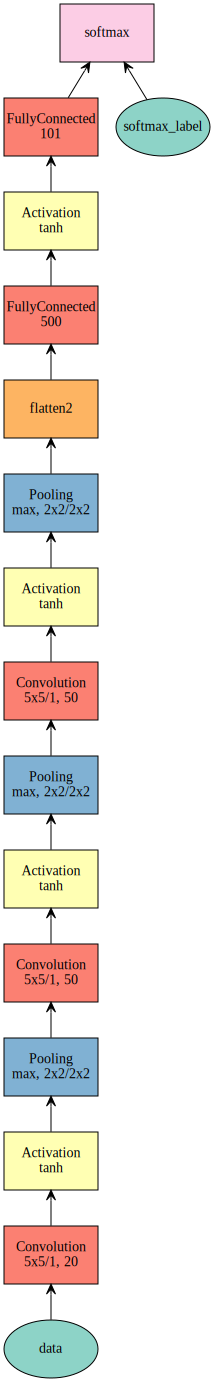

In [14]:
# Using MXNet symbols to set up a single convolutional neural network
import mxnet as mx

# Very similar to LeNet architecture with 1 additional convolution layer
def get_network(prefix):
    data = mx.sym.var('data')
    
    # Conv layer 1
    conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
    # Activation
    tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
    # Pooling for translational invariance
    pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
    
    # Conv layer 2
    conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
    tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
    pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
    
    # Conv layer 3
    conv3 = mx.sym.Convolution(data=pool2, kernel=(5,5), num_filter=50)
    tanh3 = mx.sym.Activation(data=conv3, act_type="tanh")
    pool3 = mx.sym.Pooling(data=tanh3, pool_type="max", kernel=(2,2), stride=(2,2))
    
    # First fully connected layer
    flatten = mx.sym.flatten(data=pool3)
    fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
    tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")
    
    ## TODO chhange back to 1
    # Second fully connected layer, 1 hidden layer (possible output)
    fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=101)
    
    return mx.sym.SoftmaxOutput(data=fc2, name='softmax')

network = get_network("network_1")
mx.viz.plot_network(network)

In [4]:
# Caltech 101 dataset, containing 101 classes of objects
import tarfile

fname = mx.test_utils.download(url='http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz', dirname='data', overwrite=False)
tar = tarfile.open(fname)
tar.extractall(path='./data')
tar.close()

In [2]:
# Convert into record io format
import os

# Replace with directory you have the script in
MXNET_HOME = "/home/josh/Workplace/mxnet-tests/mxnet-github"

os.system('python %s/tools/im2rec.py --list=1 --recursive=1 --shuffle=1 --test-ratio=0.2 data/caltech data/101_ObjectCategories'%MXNET_HOME)

0

In [3]:
# Create record io file
os.system("python %s/tools/im2rec.py --num-thread=4 --pass-through=1 data/caltech data/101_ObjectCategories"%MXNET_HOME)

0

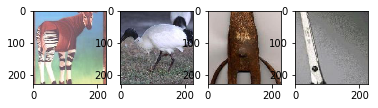

In [11]:
# MXNet image record iterator
import matplotlib.pyplot as plt
import numpy as np

data_iter = mx.io.ImageRecordIter(
    path_imgrec="./data/caltech.rec", # target record file
    data_shape=(3,227,227), #output data shape, 3 color channels, crop to 227x227
    batch_size = 4, #samples per batch
    resize=256 # resize shorter edge to 256 before cropping
    # TODO read and determine additional augmentation options
)
data_iter.reset()
batch = data_iter.next()
data = batch.data[0]
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(data[i].asnumpy().astype(np.uint8).transpose((1,2,0)))
plt.show()

This iterator is insufficient for our architecture because
1. There should be a focus on one class based on the network we are training for it
2. The label should be 0 or 1 based on the class & network matching

Thus we may have to create an iterator for each network

In [33]:
batch.label[0].asnumpy()

array([ 69.,  52.,  81.,  81.], dtype=float32)

In [22]:
import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
batch_size = 4
# create a trainable module on CPU
mlp_model = mx.mod.Module(symbol=network, context=mx.cpu())
mlp_model.fit(data_iter,  # train data
              optimizer='sgd',  # use SGD to train
              optimizer_params={'learning_rate':0.1},  # use fixed learning rate
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 10), # output progress for each 100 data batches
              num_epoch=1)  # train for at most 10 dataset passes

INFO:root:Epoch[0] Batch [10]	Speed: 4.18 samples/sec	accuracy=0.000000
INFO:root:Epoch[0] Batch [20]	Speed: 4.53 samples/sec	accuracy=0.050000
INFO:root:Epoch[0] Batch [30]	Speed: 5.20 samples/sec	accuracy=0.025000
INFO:root:Epoch[0] Batch [40]	Speed: 5.40 samples/sec	accuracy=0.025000
INFO:root:Epoch[0] Batch [50]	Speed: 5.53 samples/sec	accuracy=0.000000
INFO:root:Epoch[0] Batch [60]	Speed: 5.29 samples/sec	accuracy=0.050000
INFO:root:Epoch[0] Batch [70]	Speed: 5.19 samples/sec	accuracy=0.050000
INFO:root:Epoch[0] Batch [80]	Speed: 5.01 samples/sec	accuracy=0.050000
INFO:root:Epoch[0] Batch [90]	Speed: 4.36 samples/sec	accuracy=0.025000


KeyboardInterrupt: 